# Segmentation de clients d'un site e-commerce
### Modélisation

### 0.1 Check pep8

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

### 0.2 Import des librairies

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import p5Lib

from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn import decomposition
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score
from sklearn.base import BaseEstimator
from scipy.cluster.hierarchy import linkage
from sklearn import cluster
from sklearn.preprocessing import MinMaxScaler

In [3]:
sns.set()

### 0.2 Import des données

In [4]:
data_customers = pd.read_csv(r"Data\Cleaned\p5_data_encoded.csv")
data_customers_std = pd.read_csv(r"Data\Cleaned\p5_data_std.csv")
data = pd.read_csv(r"Data\Cleaned\p5_data.csv")

## 1. Réduction dimensionnelle par ACP

Pour éviter le ‘fléau de la dimensionnalité’ nous allons au préalable réduire les dimensions par ACP puis sélectionner un échantillon de 20000 clients aléatoires

In [5]:
data_customers = data_customers.loc[:, 'mean_price_log':]
data_customers_std = data_customers_std.loc[:, 'mean_price_log':]

In [6]:
pca = PCA()
pca.fit(data_customers_std)
scree = pca.explained_variance_ratio_*100

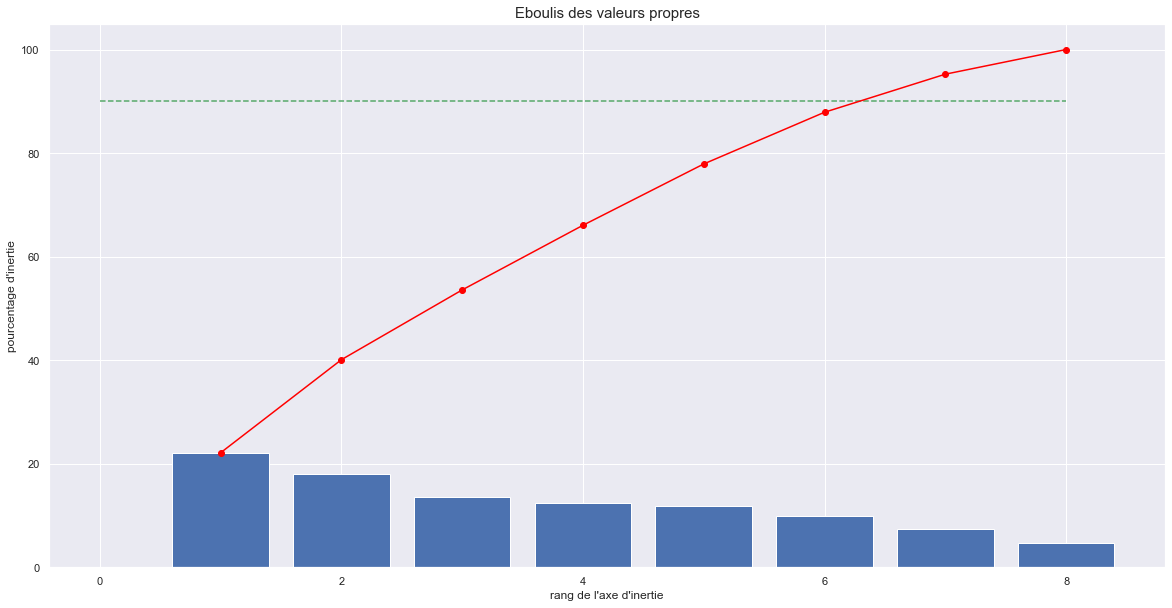

In [7]:
plt.figure(figsize=(20, 10))
plt.bar(np.arange(len(scree)) + 1, scree)
plt.plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres", fontsize=15)
plt.hlines(90, xmin=0, xmax=8, color='g', linestyles='dashed')
plt.show(block=False)

Nous sélectionnons les features afin d'avoir plus de 90% de variance expliqué

In [8]:
mask = scree.cumsum() > 90
nb_selected_features = len(scree[~mask]) + 1
print("Number of selected features:", nb_selected_features)

Number of selected features: 7


In [9]:
explained_variance_sum = scree.cumsum()[nb_selected_features-1]
print("Cumulative explained variance:  {:.2f}%".format(explained_variance_sum))

Cumulative explained variance:  95.24%


In [10]:
data_pca = pca.transform(data_customers_std)[:, :nb_selected_features]

In [11]:
col_names = [f"PCA_F{i}" for i in range(1, data_pca.shape[1]+1)]
data_PCA = pd.DataFrame(data_pca, columns=col_names)

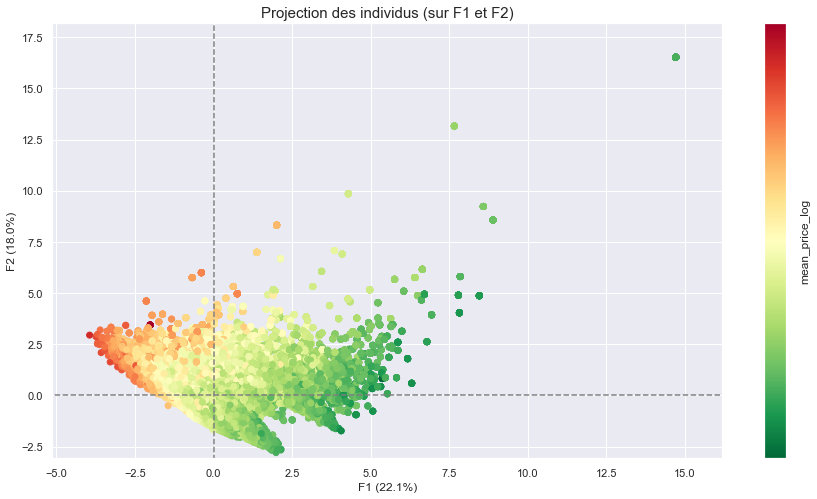

In [12]:
fig = plt.figure(figsize=(15, 8))

plt.scatter(
    data_PCA.iloc[:, 0],
    data_PCA.iloc[:, 1],
    c=data_customers_std['mean_price_log'],
    cmap=plt.cm.get_cmap('RdYlGn_r')
)

cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([])
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('mean_price_log', rotation=90)

# détermination des limites du graphique
boundary_right = np.max(np.abs(data_pca[:, 0])) * 1.1
boundary_left = np.min(data_pca[:, 0]) * 1.3
boundary_up = np.max(data_pca[:, 1]) * 1.1
boundary_down = np.min(data_pca[:, 1]) * 1.1
plt.xlim([boundary_left, boundary_right])
plt.ylim([boundary_down, boundary_up])

# affichage des lignes horizontales et verticales
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')

# nom des axes, avec le pourcentage d'inertie expliquée
plt.xlabel('F1 ({}%)'.format(
    round(100*pca.explained_variance_ratio_[0], 1))
          )
plt.ylabel('F2 ({}%)'.format(
    round(100*pca.explained_variance_ratio_[1], 1))
          )

plt.title("Projection des individus (sur F1 et F2)", fontsize=15)
plt.show(block=False)

## 2. Réduction dimensionnelle pour visualistaion (tSNE, PCA et Isomap)

In [13]:
# Sampling
X_std = data_customers_std.sample(n=20000, random_state=5)

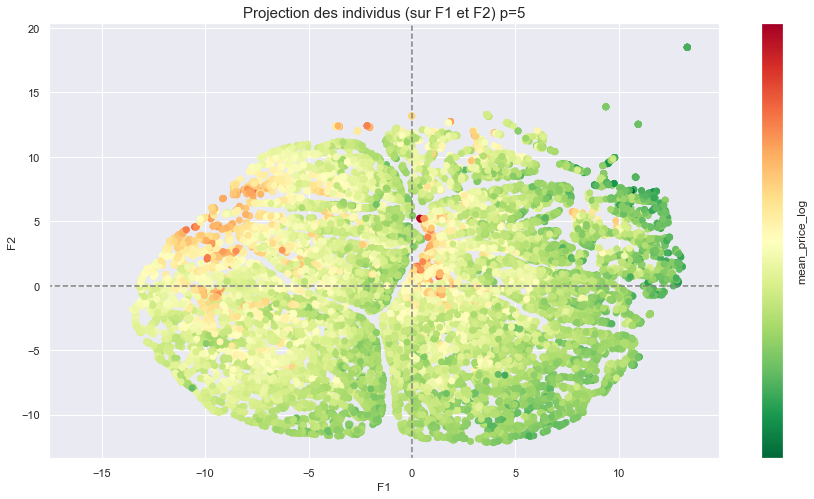

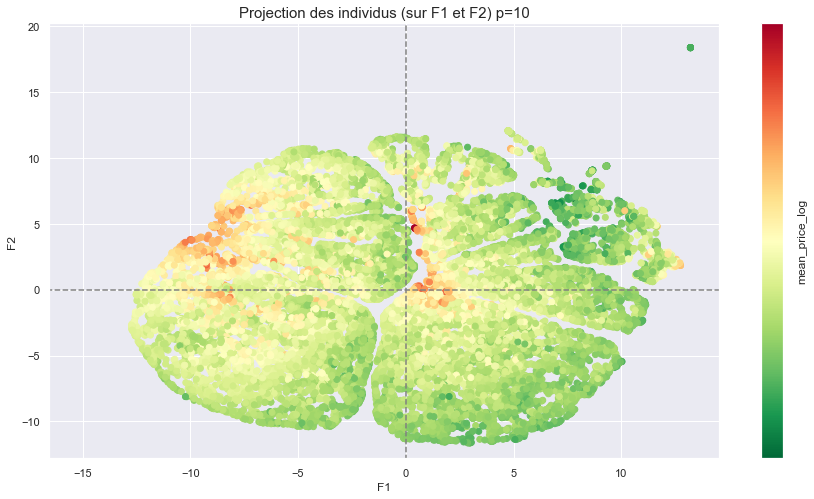

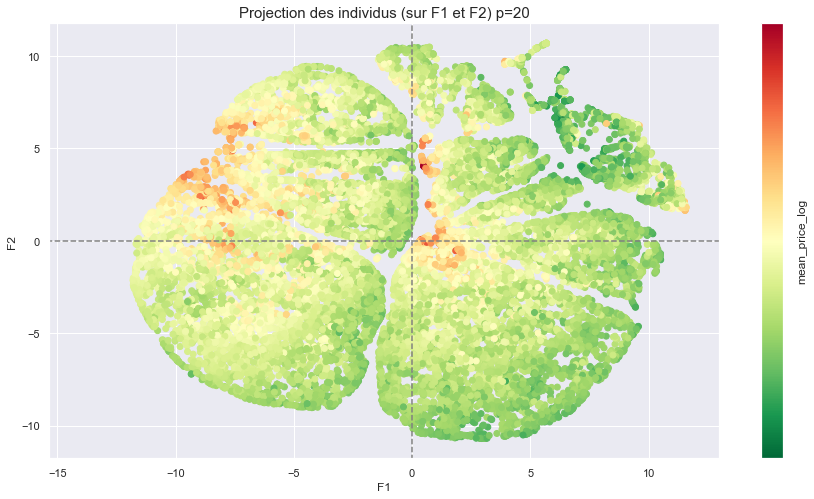

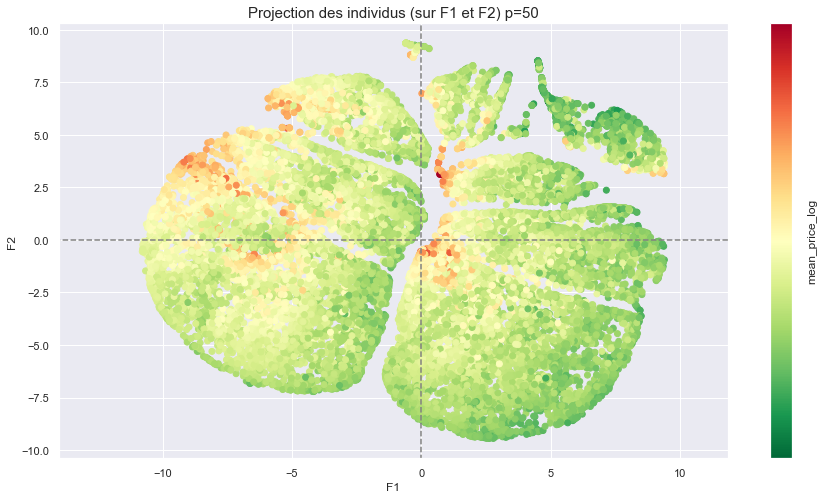

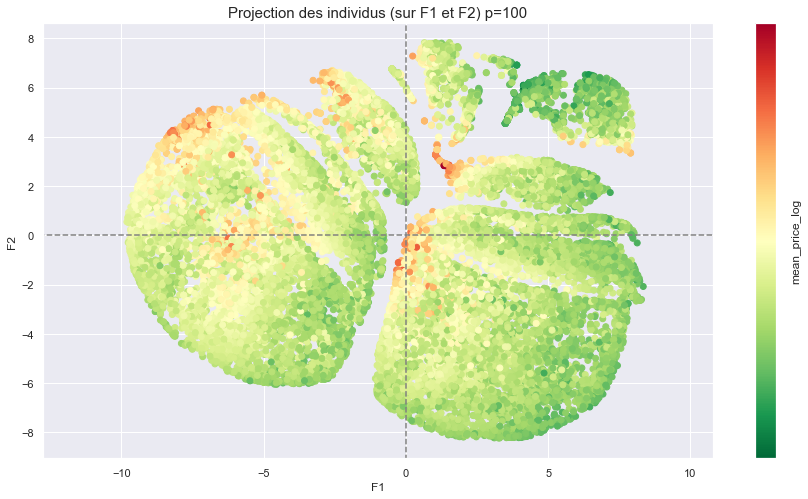

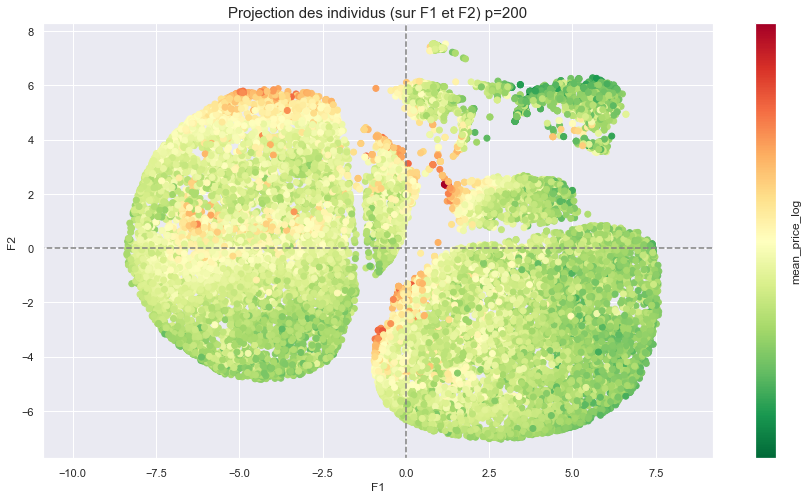

In [14]:
for perplex in [5, 10, 20, 50, 100, 200]:
    tsne = manifold.TSNE(
            n_components=2,  # for projection in a plane
            perplexity=perplex,
            n_iter=300,
            init='pca',  # initialisation by a PCA
            random_state=0
        )

    X_tsne = tsne.fit_transform(X_std)

    fig = plt.figure(figsize=(15, 8))

    plt.scatter(
        X_tsne[:, 0],
        X_tsne[:, 1],
        c=X_std['mean_price_log'],
        cmap=plt.cm.get_cmap('RdYlGn_r')
    )

    cbar = plt.colorbar()
    cbar.ax.get_yaxis().set_ticks([])
    cbar.ax.get_yaxis().labelpad = 15
    cbar.set_label('mean_price_log', rotation=90)

    # détermination des limites du graphique
    boundary_right = np.max(np.abs(X_tsne[:, 0])) * 1.1
    boundary_left = np.min(X_tsne[:, 0]) * 1.3
    boundary_up = np.max(X_tsne[:, 1]) * 1.1
    boundary_down = np.min(X_tsne[:, 1]) * 1.1
    plt.xlim([boundary_left, boundary_right])
    plt.ylim([boundary_down, boundary_up])

    # affichage des lignes horizontales et verticales
    plt.plot([-100, 100], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-100, 100], color='grey', ls='--')

    # nom des axes, avec le pourcentage d'inertie expliquée
    plt.xlabel('F1')
    plt.ylabel('F2')

    plt.title(f"Projection des individus (sur F1 et F2) p={perplex}",
              fontsize=15)
    plt.show(block=False)

Une perpelexité égale à 200 nous offre une meilleure visulalisation de la séparation de données.

In [15]:
# Instanciation of t-SNE
tsne = manifold.TSNE(
            n_components=2,  # for projection in a plane
            perplexity=200,
            n_iter=300,
            init='pca',  # initialisation by a PCA
            random_state=0
        )

# Instanciation of PCA
pca = decomposition.PCA(
            n_components=2  # for projection in a plane
        )

isomap = manifold.Isomap(
            n_components=2  # for projection in a plane
        )

X_tsne = tsne.fit_transform(X_std)
X_isomap = isomap.fit_transform(X_std)
X_pca = pca.fit_transform(X_std)

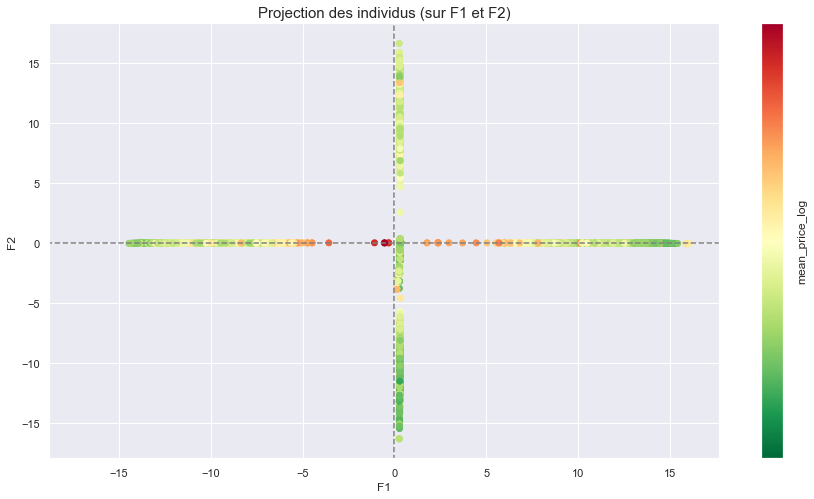

In [16]:
fig = plt.figure(figsize=(15, 8))

plt.scatter(
    X_isomap[:, 0],
    X_isomap[:, 1],
    c=X_std['mean_price_log'],
    cmap=plt.cm.get_cmap('RdYlGn_r')
)

cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([])
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('mean_price_log', rotation=90)

# détermination des limites du graphique
boundary_right = np.max(np.abs(X_isomap[:, 0])) * 1.1
boundary_left = np.min(X_isomap[:, 0]) * 1.3
boundary_up = np.max(X_isomap[:, 1]) * 1.1
boundary_down = np.min(X_isomap[:, 1]) * 1.1
plt.xlim([boundary_left, boundary_right])
plt.ylim([boundary_down, boundary_up])

# affichage des lignes horizontales et verticales
plt.plot([-100, 100], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-100, 100], color='grey', ls='--')

# nom des axes, avec le pourcentage d'inertie expliquée
plt.xlabel('F1')
plt.ylabel('F2')

plt.title("Projection des individus (sur F1 et F2)", fontsize=15)
plt.show(block=False)

## 3. Modélisation

### 3.1 Fonctions et classes utiles
#### 3.1.1 Définition des métrics d'évaluations

In [17]:
results_df = pd.DataFrame()

In [18]:
def metrics_clustering(algorithm_name,
                       standardized_features,
                       clusters_labels,
                       results_df):

    from sklearn import metrics

    # Number of clusters
    # -------------------------------------------
    nb_clusters = len(set(clusters_labels)) \
        - (1 if -1 in clusters_labels else 0)
    nb_clusters = int(nb_clusters)
    print('Estimated number of clusters (excluding noise): %d' % nb_clusters)
    results_df.loc[algorithm_name, 'Nb of clusters'] = nb_clusters

    # Silhouette score
    # -------------------------------------------
    silhouette = metrics.silhouette_score(
        standardized_features,
        clusters_labels
    )
    print("\nSilhouette coefficient: s = {:.3f}".format(silhouette))
    print("  Notice: values closer to 1 indicate a better partition")
    results_df.loc[algorithm_name, 'Silhouette'] = silhouette

    # Davies Bouldin score
    # -------------------------------------------
    davies_bouldin = metrics.davies_bouldin_score(
        standardized_features,
        clusters_labels
    )
    print("Davies Bouldin coefficient: d = {:.3f}".format(davies_bouldin))
    print("  Notice: values closer to 0 indicate a better partition")
    results_df.loc[algorithm_name, 'Davies-Bouldin'] = davies_bouldin

    # Gini coefficient
    # --------------------------------------------
    gini_coeff = p5Lib.gini(clusters_labels)
    print("\nGini coefficient: G = {:.3f}".format(gini_coeff))
    print("  Notice: values closer to 0 indicate \
    homogenic frequencies for clusters.")
    results_df.loc[algorithm_name, 'Gini'] = gini_coeff

    # Sorting the pd.DataFrame of results
    results_df = results_df.sort_values('Silhouette', ascending=False)

    print("")
    return results_df

#### 3.1.2 Optimisation des hyperparamètres

In [19]:
%pycodestyle_off
class GridSearch(BaseEstimator):
    """Classe permettant d'implémenter une recherche exhaustive sur grille
    (sans validation croisée) pour les algorithmes de clustering."""

    # Method: init
    # ------------------------------------------------------------------------------
    def __init__(
            self,
            estimator,  # clustering algorithm to test
            param_grid,  # research space for hyperparameters
            scoring=None):
        """Méthode d'initialisation prenant en entrée le modèle
        à tester et la grille de paramètres."""

        # getting parameters
        self.estimator = estimator
        self.param_grid = param_grid
        self.scoring = scoring

    # Method: fit
    # ------------------------------------------------------------------------------
    def fit(self, X):
        """Méthode permettant de réaliser la recherche sur grille,
        et renvoyant le meilleur modèle trouvé, ré-entraîné sur les données."""

        # initialization of the dict of results
        self.results_ = {"scores": [],
                         "params": [],
                         "models": [],
                         "fit_times": [],
                         "nb_clusters": [],
                         "gini_coef": [],
                         "davies_bouldin": []}

        # Loading modules
        from sklearn.model_selection import ParameterGrid

        # iterating upon all combinations of parameters
        for param_combination in ParameterGrid(param_grid):

            # instanciation of the model with selected parameters
            model = self.estimator(**param_combination)

            # Measuring training time while fitting the model on the data
            time_train = %timeit -n1 -r1 -o -q model.fit(X)
            time_train = time_train.average

            # Scoring the model
            if not self.scoring:  # if scoring parameter not defined
                model_score = model.score(X)
            else:  # if scoring parameter is defined
                try:
                    labels = model.labels_
                    model_score = self.scoring(X, labels)
                except model_score.DoesNotExist:
                    model_score = np.nan

            # Computing number of clusters, excluding noise (#-1)
            nb_clusters = \
                len(set(model.labels_)) - (1 if -1 in clusters_labels else 0)
            nb_clusters = int(nb_clusters)

            # Computing Gini coefficient
            gini_coeff = p5Lib.gini(model.labels_)

            from sklearn import metrics
            # Computing Davies Bouldin index
            davies_bouldin = metrics.davies_bouldin_score(X, labels)

            # saving results, parameters and models in a dict
            self.results_["scores"].append(model_score)  # scores
            self.results_["params"].append(param_combination)  # parameters
            self.results_["models"].append(model)  # trained models
            self.results_["fit_times"].append(time_train)  # training time
            self.results_["gini_coef"].append(gini_coeff)  # Gini coefficient
            self.results_["nb_clusters"].append(nb_clusters)  # nb of clusters
            self.results_["davies_bouldin"].append(davies_bouldin)

        # Selecting best model (assumes that 'greater is better')
        # -----------------------------------
        best_model_index, best_score = None, None  # initialisation
        # iterating over scores
        for index, score in enumerate(self.results_["scores"]):

            # initialisation
            if not best_score:
                best_score = score
                best_model_index = index

            # if score is better than current best_score
            if score > best_score:
                # update the current best_score and current best_model_index
                best_score = score
                best_model_index = index

        # Update attributes of the instance
        self.best_score_ = self.results_["scores"][best_model_index]
        self.best_params_ = self.results_["params"][best_model_index]
        self.best_estimator_ = self.results_["models"][best_model_index]
        self.best_index_ = best_model_index
        self.refit_time_ = self.results_["fit_times"][best_model_index]

        return self

    # Method: predict
    # ------------------------------------------------------------------------------
    def predict(self, X_test):
        """Méthode permettant de réaliser les prédictions sur le jeu de test,
        en utilisant le meilleur modèle trouvé avec la méthode .fit
        entraîné sur le jeu d'entraînement complet."""

        # use the .predict method of the estimator on the best model
        return self.best_model.predict(X_test)
%pycodestyle_on

#### Affichage des résultats

In [20]:
def plot_clusters(
        standardized_features,
        clusters_labels,
        embedding_algo='tSNE',
        ax=None):
    """
    Arguments:
    ---------
    embedding_algo: 'tSNE' or 'PCA' or 'Isomap'
    """

    # Applying the embedding
    # -----------------
    # Import libraries
    from sklearn import manifold
    from sklearn import decomposition

    # Instanciation of the embedding
    if embedding_algo == 'tSNE':
        X_projected = X_tsne

    elif embedding_algo == 'Isomap':
        X_projected = X_isomap

    elif embedding_algo == 'PCA':
        X_projected = X_pca

    # Plotting the Isomap embedding
    # -----------------------------

    # If no axes is passed…
    if not ax:
        # Set the axes to the current one
        ax = plt.gca()  # ax = ax or plt.gca()
        # Set dimensions of the figure (if no axes is passed)
        plt.gcf().set_figwidth(12)
        plt.gcf().set_figheight(7)

    # Definitions of axis boundaries
    ax.set_xlim(X_projected[:, 0].min()*1.1, X_projected[:, 0].max()*1.1)
    ax.set_ylim(X_projected[:, 1].min()*1.1, X_projected[:, 1].max()*1.1)

    # Properties of the axes
    ax.set_title(embedding_algo, fontsize=20)

    if embedding_algo == 'PCA':
        # Names of x- and y- axis, with percentage of explained variance
        ax.set_xlabel('First component ({}%)'
                      .format(round(100*pca.explained_variance_ratio_[0], 1)))
        ax.set_ylabel('Second component ({}%)'
                      .format(round(100*pca.explained_variance_ratio_[1], 1)))
    else:
        ax.set_xlabel('First component')
        ax.set_ylabel('Second component')

    # Setting color
    NB_CLUSTERS = \
        len(set(clusters_labels)) - (1 if -1 in clusters_labels else 0)
    color = clusters_labels / NB_CLUSTERS

    # Setting color to black for noise points
    # color = pd.Series(clusters_labels / NB_CLUSTERS).astype('object')
    # color = color.map(lambda x: x if x != (-1 / NB_CLUSTERS) else 'black')

    # Plotting the scatter plot
    ax.scatter(
            X_projected[:, 0],  # x-coordinate
            X_projected[:, 1],  # y-coordinate
            c=color,  # base for coloration of points
            cmap=plt.cm.get_cmap('Set1'),  # colormap
            )

In [21]:
def clustering_plots(algorithm_name, standardized_features, clusters_labels):

    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    fig = plt.figure()

    # Set properties of the figure
    fig.set_figheight(6)
    fig.set_figwidth(23)
    fig.suptitle('Visualisation of clustering with {}'
                 .format(algorithm_name), fontsize=20)

    # Set the geometry of the grid of subplots
    gs = gridspec.GridSpec(nrows=1, ncols=3,)

    # Initialize axes and set position (left to right, top to bottom)
    # Use sharex or sharey parameter for sharing axis
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])

    # Filling the axes
    plot_clusters(
        standardized_features,
        clusters_labels,
        embedding_algo='tSNE',
        ax=ax1
    )
    plot_clusters(
        standardized_features,
        clusters_labels,
        embedding_algo='PCA',
        ax=ax2
    )
    plot_clusters(
        standardized_features,
        clusters_labels,
        embedding_algo='Isomap',
        ax=ax3
    )

    # Automatically adjusts subplots params to fit the figure
    gs.tight_layout(fig, rect=[0, 0, 1, 0.96])

### 3.2 Modèle naïf

In [22]:
algorithm_name = 'Naïve model'
standardized_features = X_std

# Random labels (0 or 1)
clusters_labels = np.random.randint(2, size=len(standardized_features))

metrics_clustering(
    algorithm_name,
    standardized_features,
    clusters_labels,
    results_df
)

Estimated number of clusters (excluding noise): 2

Silhouette coefficient: s = -0.000
  Notice: values closer to 1 indicate a better partition
Davies Bouldin coefficient: d = 156.516
  Notice: values closer to 0 indicate a better partition

Gini coefficient: G = 0.002
  Notice: values closer to 0 indicate     homogenic frequencies for clusters.



Nb of clusters  Silhouette  Davies-Bouldin     Gini
Naïve model             2.0   -0.000044       156.51573  0.00205

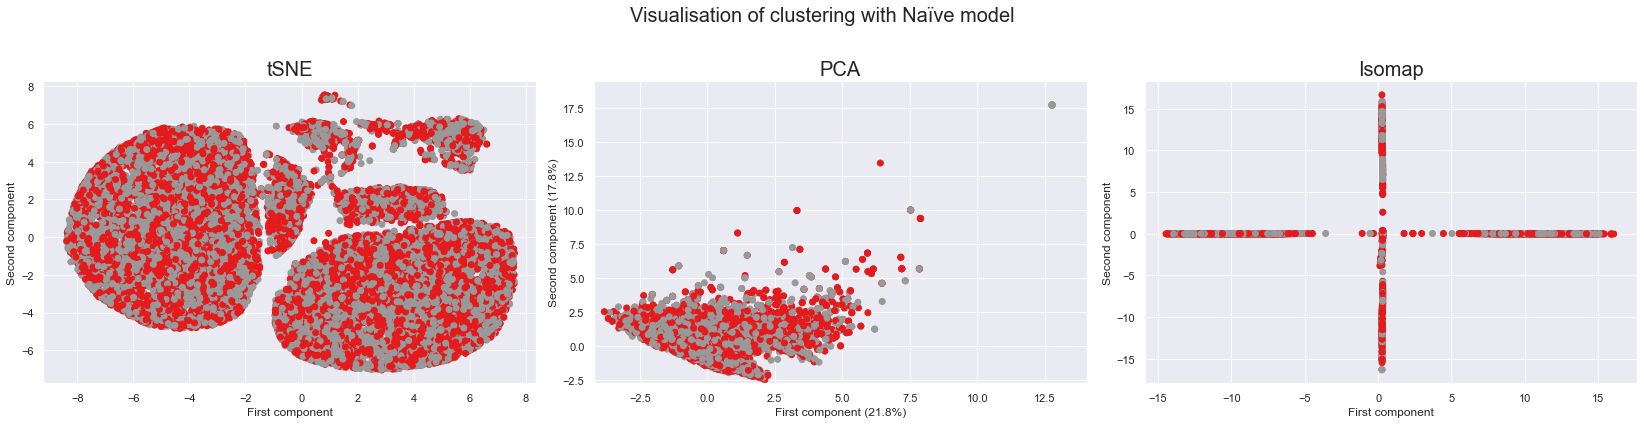

In [23]:
clustering_plots(algorithm_name, standardized_features, clusters_labels)

### 3.3 Hierarchical clustering

In [24]:
# Definition of the search space for hyperparameters
param_grid = [
    {
        # number of clusters to find
        'n_clusters': range(4, 10),
        # linkage criterion to use
        'linkage': ['complete', 'average', 'single'],
        # Metric used to compute the linkage
        'affinity': ['euclidean', 'manhattan', 'cosine']
    },

    {
        'n_clusters': range(4, 10),  # number of clusters to find
        'linkage': ['ward'],  # linkage criterion to use
    }
]

In [25]:
# instanciation of the GridSearch object
hierarchy_search = GridSearch(
    estimator=AgglomerativeClustering,
    param_grid=param_grid,
    scoring=silhouette_score,
)

# Proceeding the grid search
hierarchy_search.fit(X_std)

# Displays best parameters
print("Best hyperparameters:", hierarchy_search.best_params_)
print("Best Silhouette score:", hierarchy_search.best_score_)
print("Training time:", hierarchy_search.refit_time_)

Best hyperparameters: {'affinity': 'euclidean', 'linkage': 'average', 'n_clusters': 4}
Best Silhouette score: 0.83311144703499
Training time: 14.61122499999999


In [26]:
pd.DataFrame(hierarchy_search.results_)\
    .sort_values('scores', ascending=False).head(20)

scores                                             params  \
30  0.833111  {'affinity': 'manhattan', 'linkage': 'single',...   
6   0.833111  {'affinity': 'euclidean', 'linkage': 'average'...   
12  0.833111  {'affinity': 'euclidean', 'linkage': 'single',...   
31  0.695428  {'affinity': 'manhattan', 'linkage': 'single',...   
13  0.695428  {'affinity': 'euclidean', 'linkage': 'single',...   
32  0.694674  {'affinity': 'manhattan', 'linkage': 'single',...   
14  0.694674  {'affinity': 'euclidean', 'linkage': 'single',...   
15  0.694451  {'affinity': 'euclidean', 'linkage': 'single',...   
33  0.694210  {'affinity': 'manhattan', 'linkage': 'single',...   
24  0.674758  {'affinity': 'manhattan', 'linkage': 'average'...   
25  0.674530  {'affinity': 'manhattan', 'linkage': 'average'...   
7   0.671767  {'affinity': 'euclidean', 'linkage': 'average'...   
26  0.659955  {'affinity': 'manhattan', 'linkage': 'average'...   
34  0.659633  {'affinity': 'manhattan', 'linkage': 'single',...   
8   0.623327  {'affinity': 'euclidean', 'linkage': 'average'...   
9   0.622578  {'affinity': 'euclidean', 'linkage': 'average'...   
17  0.616327  {'affinity': 'euclidean', 'linkage': 'single',...   
16  0.616309  {'affinity': 'euclidean', 'linkage': 'single',...   
35  0.610584  {'affinity': 'manhattan', 'linkage': 'single',...   
10  0.590846  {'affinity': 'euclidean', 'linkage': 'average'...   

                                               models  fit_times  nb_clusters  \
30  AgglomerativeClustering(affinity='manhattan', ...   2.182725            4   
6   AgglomerativeClustering(linkage='average', n_c...  14.611225            4   
12  AgglomerativeClustering(linkage='single', n_cl...   2.767975            4   
31  AgglomerativeClustering(affinity='manhattan', ...   2.210692            5   
13  AgglomerativeClustering(linkage='single', n_cl...   2.783189            5   
32  AgglomerativeClustering(affinity='manhattan', ...   2.198700            6   
14  AgglomerativeClustering(linkage='single', n_cl...   2.782865            6   
15  AgglomerativeClustering(linkage='single', n_cl...   2.768879            7   
33  AgglomerativeClustering(affinity='manhattan', ...   2.203273            7   
24  AgglomerativeClustering(affinity='manhattan', ...  15.097455            4   
25  AgglomerativeClustering(affinity='manhattan', ...  14.305981            5   
7   AgglomerativeClustering(linkage='average', n_c...  14.735949            5   
26  AgglomerativeClustering(affinity='manhattan', ...  14.250094            6   
34  AgglomerativeClustering(affinity='manhattan', ...   2.182095            8   
8   AgglomerativeClustering(linkage='average', n_c...  14.706272            6   
9   AgglomerativeClustering(linkage='average', n_c...  15.244713            7   
17  AgglomerativeClustering(linkage='single', n_cl...   2.774668            9   
16  AgglomerativeClustering(linkage='single', n_cl...   2.804506            8   
35  AgglomerativeClustering(affinity='manhattan', ...   2.181049            9   
10  AgglomerativeClustering(linkage='average', n_c...  14.704978            8   

    gini_coef  davies_bouldin  
30   0.749250        0.099906  
6    0.749250        0.099906  
12   0.749250        0.099906  
31   0.799100        0.143423  
13   0.799100        0.143423  
32   0.831683        0.184430  
14   0.831683        0.184430  
15   0.855443        0.183992  
33   0.855493        0.153105  
24   0.746200        0.399575  
25   0.796200        0.300889  
7    0.796600        0.359252  
26   0.826983        0.389818  
34   0.873200        0.166943  
8    0.824583        0.438894  
9    0.848393        0.435224  
17   0.886889        0.176895  
16   0.873000        0.195645  
35   0.886789        0.183360  
10   0.866250        0.454562

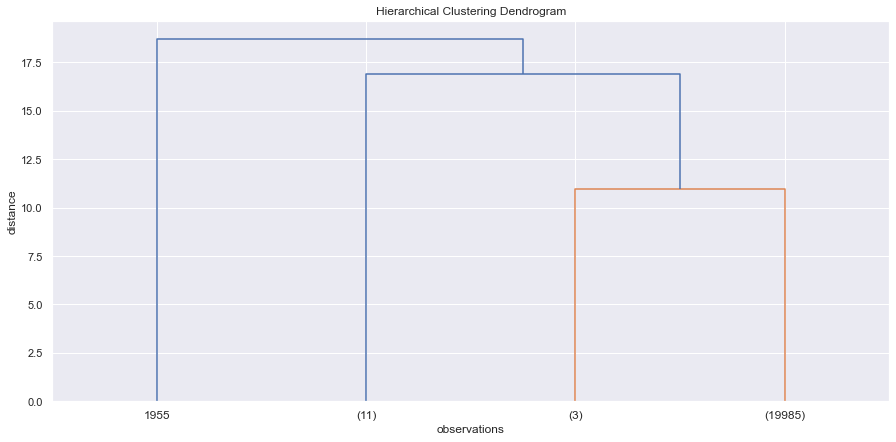

In [27]:
def plot_dendrogram(Z, labels=[], p=10):
    """This function plots the dendogram.
    Parameters:
    ----------
        - Z : linkage. Ex: Z = linkage(X_std, 'ward')
        - labels : names of the points
        - p : numbers of clusters to stop"""

    from scipy.cluster.hierarchy import dendrogram

    plt.figure(figsize=(15, 7))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('observations')
    plt.ylabel('distance')
    dendrogram(
        Z,
        p=p,
        # labels = names,
        truncate_mode="lastp"
    )
    plt.show()


# Clustering hiérarchique (critère de Ward)
Z = linkage(X_std, method='single', metric='cityblock')

# number of clusters for truncating dendogram
p = 4

# plotting the dendogram
plot_dendrogram(Z, p=p)

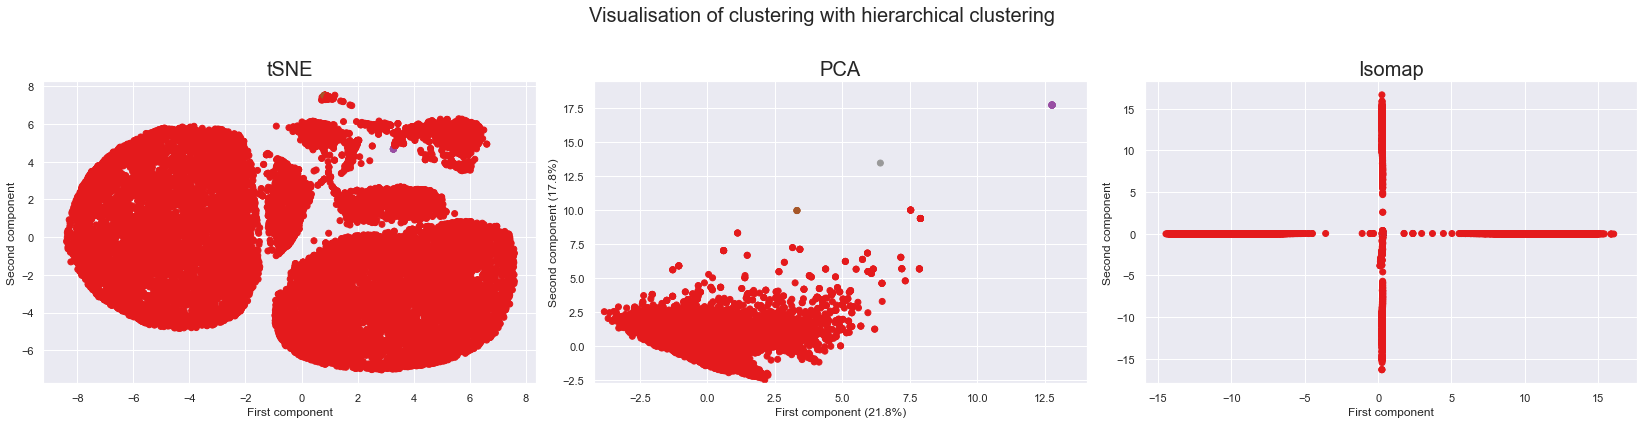

In [28]:
algorithm_name = 'hierarchical clustering'
standardized_features = X_std
clusters_labels = hierarchy_search.best_estimator_.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

In [29]:
metrics_clustering(
    algorithm_name,
    standardized_features,
    clusters_labels,
    results_df
)

Estimated number of clusters (excluding noise): 4

Silhouette coefficient: s = 0.833
  Notice: values closer to 1 indicate a better partition
Davies Bouldin coefficient: d = 0.100
  Notice: values closer to 0 indicate a better partition

Gini coefficient: G = 0.749
  Notice: values closer to 0 indicate     homogenic frequencies for clusters.



Nb of clusters  Silhouette  Davies-Bouldin     Gini
hierarchical clustering             4.0    0.833111        0.099906  0.74925
Naïve model                         2.0   -0.000044      156.515730  0.00205

Text(0.5, 1.0, 'Distribution des clusters')

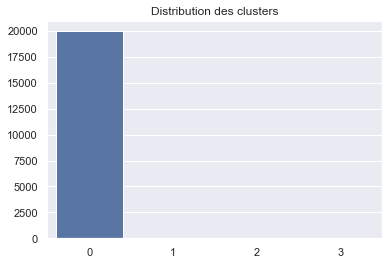

In [30]:
sns.barplot(x=pd.Series(clusters_labels).value_counts().index,
            y=pd.Series(clusters_labels).value_counts().values)
plt.title("Distribution des clusters")

### 3.4 K-Means

In [31]:
param_grid = {
    "n_clusters":  range(2, 14),  # number of clusters
}

In [32]:
kmeans_search = GridSearch(
    estimator=cluster.KMeans,
    param_grid=param_grid,
    scoring=silhouette_score,
)

# Proceeding the grid search
kmeans_search.fit(X_std)

# Displays best parameters
print("Best hyperparameters:", kmeans_search.best_params_)
print("Best Silhouette score:", kmeans_search.best_score_)
print("Training time:", kmeans_search.refit_time_)

Best hyperparameters: {'n_clusters': 5}
Best Silhouette score: 0.24384024076792843
Training time: 0.4727444000000105


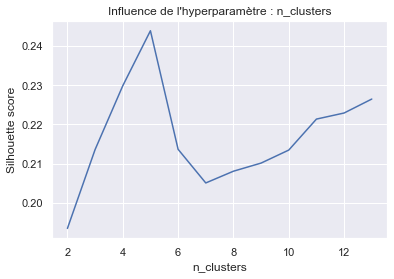

In [33]:
# Getting the list of parameters and list of scores
n_clusters_list = [kmeans_search.results_['params'][i]['n_clusters']
                   for i in range(len(kmeans_search.results_['params']))]
scores_list = kmeans_search.results_['scores']

# Plotting the influence of the single hyperparameter
x = n_clusters_list
y = scores_list
plt.xlabel("n_clusters")
plt.ylabel("Silhouette score")
plt.title("Influence de l'hyperparamètre : n_clusters")
plt.plot(x, y)

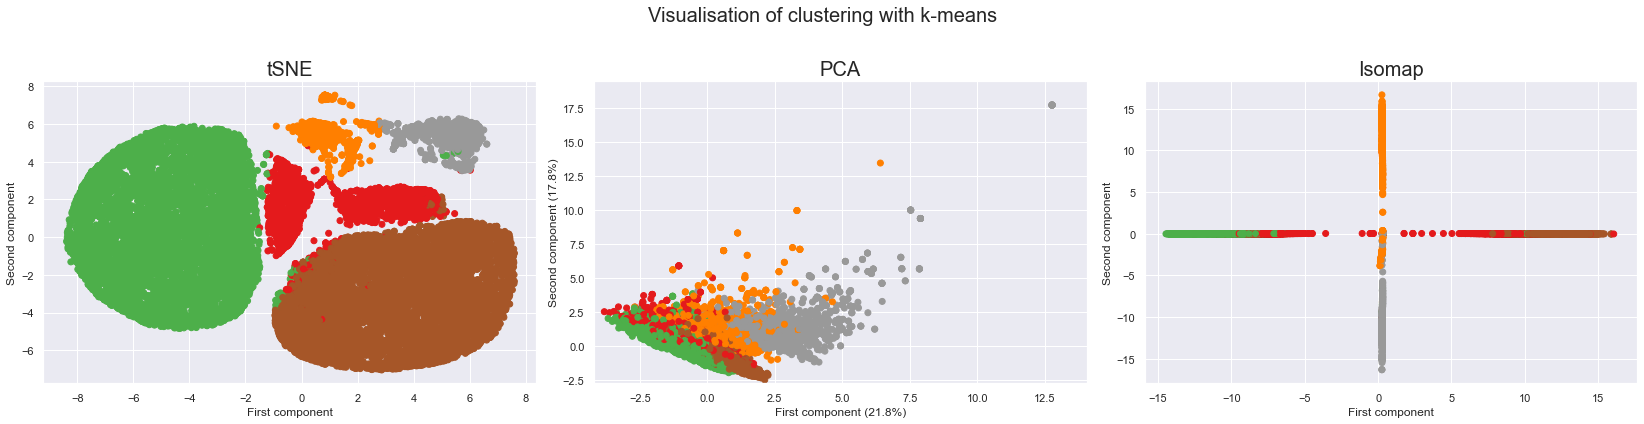

In [34]:
# Setup for call to the clustering_plots function
algorithm_name = 'k-means'
standardized_features = X_std
clusters_labels = kmeans_search.best_estimator_.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

In [35]:
# Computes and displays results
metrics_clustering(
    algorithm_name,
    standardized_features,
    clusters_labels,
    results_df
)

Estimated number of clusters (excluding noise): 5

Silhouette coefficient: s = 0.244
  Notice: values closer to 1 indicate a better partition
Davies Bouldin coefficient: d = 1.365
  Notice: values closer to 0 indicate a better partition

Gini coefficient: G = 0.331
  Notice: values closer to 0 indicate     homogenic frequencies for clusters.



Nb of clusters  Silhouette  Davies-Bouldin     Gini
hierarchical clustering             4.0    0.833111        0.099906  0.74925
k-means                             5.0    0.243840        1.364771  0.33085
Naïve model                         2.0   -0.000044      156.515730  0.00205

<AxesSubplot:>

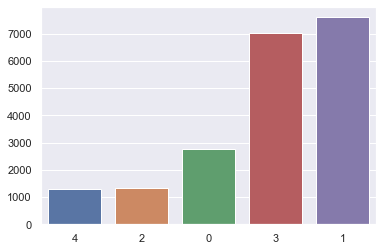

In [36]:
sns.barplot(
    x=pd.Series(clusters_labels).value_counts().sort_values().index,
    y=pd.Series(clusters_labels).value_counts().sort_values().values,
    order=pd.Series(clusters_labels).value_counts().sort_values().index)

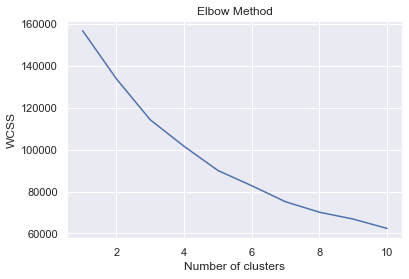

In [101]:
wcss = []
for i in range(1, 11):
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(X_std)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### 3.5 DBSCAN

In [37]:
# Definition of the search space for hyperparameters
param_grid = {
    # maximum distance that define neighborhood
    'eps': [0.05, 0.1, 0.25, 0.5, 1, 2, 4],
    # nb of neighbors to be considered as a core point
    'min_samples': range(5, 10),
    'n_jobs': [-1]
}

In [38]:
# instanciation of the GridSearch object
dbscan_search = GridSearch(
    estimator=DBSCAN,
    param_grid=param_grid,
    scoring=silhouette_score,
)

# Proceeding the grid search
dbscan_search.fit(X_std)

# Displays best parameters
print("Best hyperparameters:", dbscan_search.best_params_)
print("Best Silhouette score:", dbscan_search.best_score_)
print("Training time:", dbscan_search.refit_time_)

Best hyperparameters: {'eps': 4, 'min_samples': 5, 'n_jobs': -1}
Best Silhouette score: 0.7477237945739359
Training time: 4.824338099999977


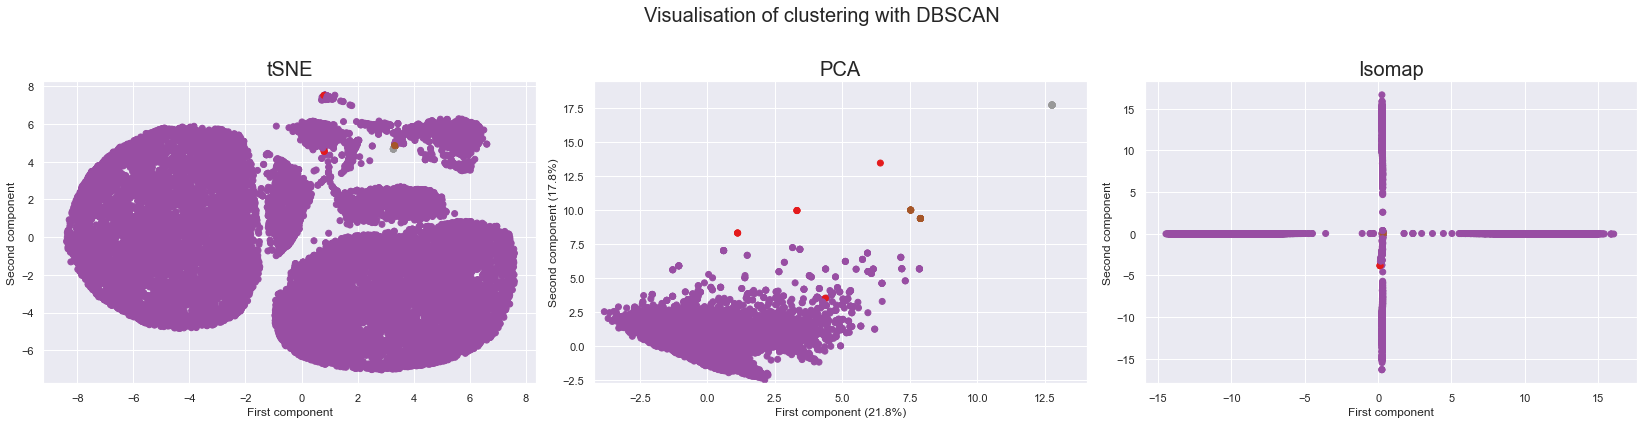

In [39]:
# Setup for call to the clustering_plots function
algorithm_name = 'DBSCAN'
standardized_features = X_std
clusters_labels = dbscan_search.best_estimator_.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

In [40]:
# Setup for call to the clustering_plots function
algorithm_name = 'DBSCAN'
standardized_features = X_std
clusters_labels = dbscan_search.best_estimator_.labels_

# Computes and displays results
metrics_clustering(
    algorithm_name,
    standardized_features,
    clusters_labels,
    results_df
)

Estimated number of clusters (excluding noise): 3

Silhouette coefficient: s = 0.748
  Notice: values closer to 1 indicate a better partition
Davies Bouldin coefficient: d = 0.527
  Notice: values closer to 0 indicate a better partition

Gini coefficient: G = 0.748
  Notice: values closer to 0 indicate     homogenic frequencies for clusters.



Nb of clusters  Silhouette  Davies-Bouldin     Gini
hierarchical clustering             4.0    0.833111        0.099906  0.74925
DBSCAN                              3.0    0.747724        0.526513  0.74830
k-means                             5.0    0.243840        1.364771  0.33085
Naïve model                         2.0   -0.000044      156.515730  0.00205

<AxesSubplot:>

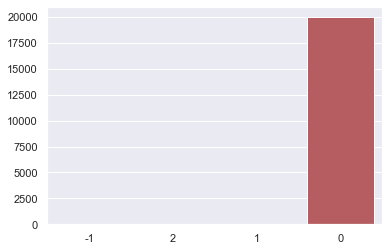

In [41]:
sns.barplot(
    x=pd.Series(clusters_labels).value_counts().sort_values().index,
    y=pd.Series(clusters_labels).value_counts().sort_values().values,
    order=pd.Series(clusters_labels).value_counts().sort_values().index)

### 3.6 Optics

In [42]:
# Definition of the search space for hyperparameters
param_grid = {
    # number of neighbors to be considered as a core point
    'min_samples': [3, 5, 10],
    'xi': [0.05, 0.1, 0.2],
    'min_cluster_size': [0.01, 0.05],
}

# instanciation of the GridSearch object
optics_search = GridSearch(
    estimator=OPTICS,
    param_grid=param_grid,
    scoring=silhouette_score,
)

# Proceeding the grid search
optics_search.fit(X_std)

# Displays best parameters
print("Best hyperparameters:", optics_search.best_params_)
print("Best Silhouette score:", optics_search.best_score_)

C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Best hyperparameters: {'min_cluster_size': 0.01, 'min_samples': 3, 'xi': 0.2}
Best Silhouette score: 0.8699011818424549


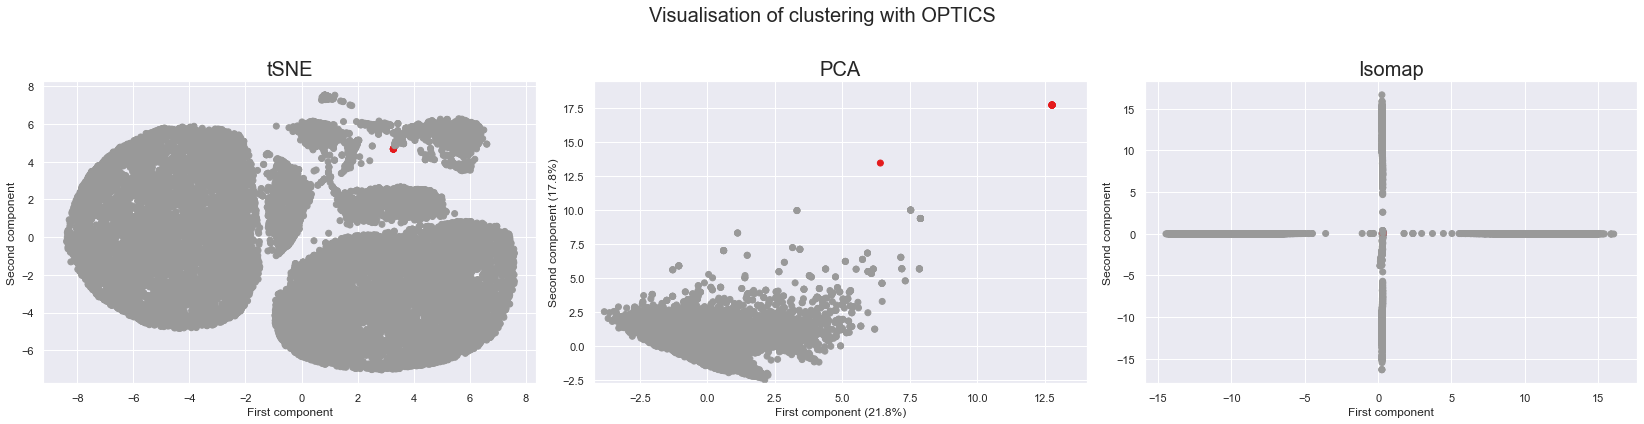

In [43]:
# Setup for call to the clustering_plots function
algorithm_name = 'OPTICS'
standardized_features = X_std
clusters_labels = optics_search.best_estimator_.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

In [44]:
algorithm_name = 'OPTICS'
standardized_features = X_std
clusters_labels = optics_search.best_estimator_.labels_

# Computes and displays results
metrics_clustering(
    algorithm_name,
    standardized_features,
    clusters_labels,
    results_df
)

Estimated number of clusters (excluding noise): 1

Silhouette coefficient: s = 0.870
  Notice: values closer to 1 indicate a better partition
Davies Bouldin coefficient: d = 0.333
  Notice: values closer to 0 indicate a better partition

Gini coefficient: G = 0.499
  Notice: values closer to 0 indicate     homogenic frequencies for clusters.



Nb of clusters  Silhouette  Davies-Bouldin     Gini
OPTICS                              1.0    0.869901        0.333434  0.49940
hierarchical clustering             4.0    0.833111        0.099906  0.74925
DBSCAN                              3.0    0.747724        0.526513  0.74830
k-means                             5.0    0.243840        1.364771  0.33085
Naïve model                         2.0   -0.000044      156.515730  0.00205

<AxesSubplot:>

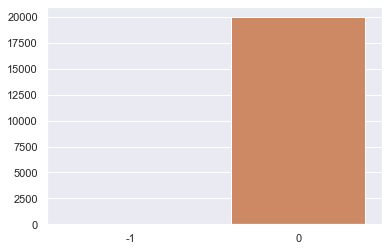

In [45]:
sns.barplot(
    x=pd.Series(clusters_labels).value_counts().sort_values().index,
    y=pd.Series(clusters_labels).value_counts().sort_values().values,
    order=pd.Series(clusters_labels).value_counts().sort_values().index)

## 4. Analyse et interprétation

In [102]:
model = kmeans_search.best_estimator_
# model = dbscan_search.best_estimator_

In [103]:
kmeans_search.best_estimator_

KMeans(n_clusters=5, random_state=5)

In [104]:
# Getting the original standardized features for customers
standardized_features = pd.read_csv(r"data\cleaned\p5_data_std.csv")
standardized_features = standardized_features.loc[:, 'mean_price_log':]

# Re-fitting the algorithm
model.fit(X_std)
clusters_labels = model.labels_

# Creating a mask for the sample
mask = standardized_features.index.isin(X_std.index)

# Keeping data only for the sample
standardized_features = standardized_features[mask]

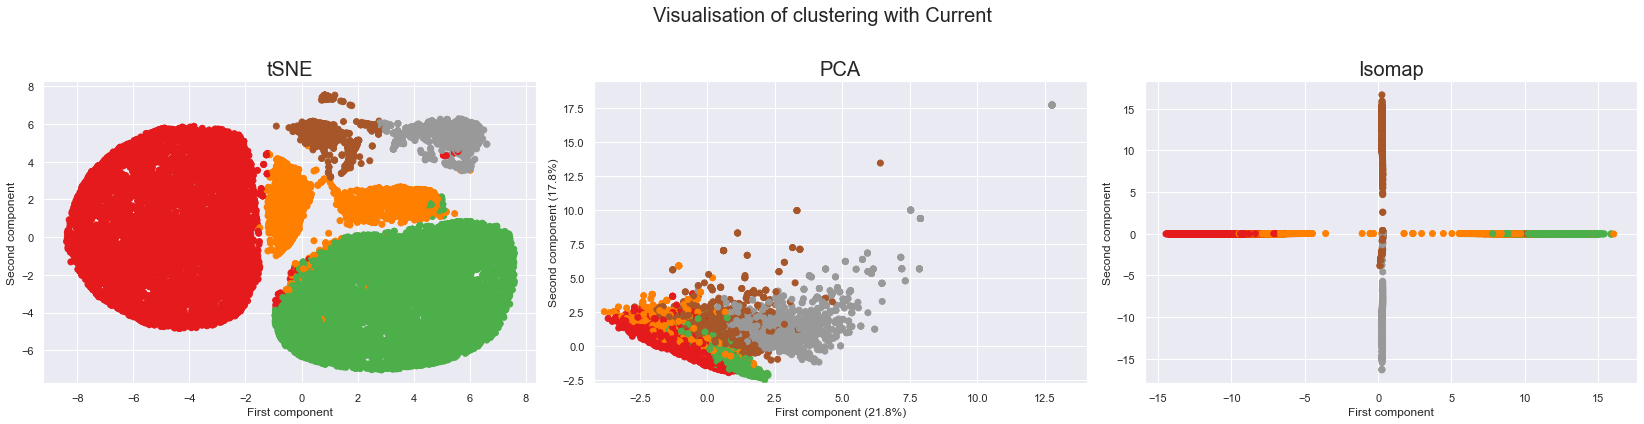

In [105]:
# Embedding by tSNE, PCA and Isomap
clustering_plots(
    algorithm_name='Current',
    standardized_features=X_std,
    clusters_labels=model.labels_
)

<AxesSubplot:>

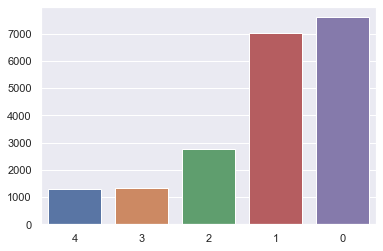

In [106]:
sns.barplot(
    x=pd.Series(clusters_labels).value_counts().sort_values().index,
    y=pd.Series(clusters_labels).value_counts().sort_values().values,
    order=pd.Series(clusters_labels).value_counts().sort_values().index)

In [107]:
# Convert labels to pandas.DataFrame
clusters_labels = pd.Series(clusters_labels)
clusters_labels = clusters_labels.to_frame('cluster_labels')

# Get the list of clusters
list_clusters = clusters_labels['cluster_labels'].unique()
list_clusters.sort()

# Display frequencies for clusters
clusters_labels['cluster_labels'].value_counts(normalize=True, sort=False)

0    0.38005
1    0.35080
2    0.13735
3    0.06660
4    0.06520
Name: cluster_labels, dtype: float64

In [108]:
# Rescale the features from 0 to 100
scaler = MinMaxScaler(feature_range=(0, 100))
scaled_features = scaler.fit_transform(X_std)

# Convert back to a pd.DataFrame
features_names = standardized_features.columns
scaled_features = pd.DataFrame(scaled_features, columns=features_names)

In [109]:
# Get the name of features
features_names = scaled_features.columns

# Initializing a pd.DataFrame to store aggregate values
clusters_agg_df = pd.DataFrame(
    columns=[feature_name for feature_name in features_names]
)

# Iterating upon clusters
for cluster_index in list_clusters:

    # Getting elements of the cluster
    mask = (clusters_labels['cluster_labels'] == cluster_index)

    # For each feature. Could be vectorized.
    for feature in scaled_features.columns:
        # compute the mean
        mean_of_feature_for_cluster = scaled_features[mask][feature].mean()
        clusters_agg_df.loc[cluster_index, feature] = \
            mean_of_feature_for_cluster
        # compute the standard deviation
        std_of_feature_for_cluster = \
            scaled_features[mask][feature].std()
        clusters_agg_df.loc[cluster_index, feature+'_std'] =\
            std_of_feature_for_cluster

# Compute the data for the 'mean customer'
for feature in scaled_features.columns:
    # compute the mean
    mean_of_feature = scaled_features[feature].mean()
    clusters_agg_df.loc['mean customer', feature] = mean_of_feature
    # compute the standard deviation
    std_of_feature = scaled_features[feature].std()
    clusters_agg_df.loc['mean customer', feature+'_std'] = std_of_feature
    # compute the standard deviation
    median_of_feature = scaled_features[feature].median()
    clusters_agg_df.loc['median customer', feature] = median_of_feature

clusters_agg_df.head(10)

mean_price_log mean_review_score mean_product_volume_log  \
0                      42.0305           89.3534                 46.5915   
1                      35.9642           89.7894                 41.1307   
2                      43.0429           6.95759                 46.0893   
3                      39.2457           78.5507                 44.0594   
4                      27.5449           76.3329                 46.0944   
mean customer          38.9116           76.6209                 44.4058   
median customer          38.24               100                 43.2746   

                one_payement_percent unique_paym_seq_percent recency_Score  \
0                            0.51309                 99.9474       34.5822   
1                                100                     100       33.3035   
2                            45.0309                 99.8726        33.143   
3                            44.5428                 98.2463       31.7281   
4                            84.7163                 39.5442        37.578   
mean customer                49.9501                  95.904       33.9412   
median customer                   50                     100       31.0507   

                  nb_orders count_review_comment  mean_price_log_std  \
0                         0             0.463133            9.731660   
1                         0             0.355943            8.775854   
2                0.00840077              1.25395           10.905075   
3                   9.53453              3.66549            8.570690   
4                  0.448325              5.93911            9.161996   
mean customer      0.665385              1.10446           10.354304   
median customer           0                    0                 NaN   

                 mean_review_score_std  mean_product_volume_log_std  \
0                            16.625161                    18.962486   
1                            16.447751                    18.173471   
2                            13.464154                    19.254619   
3                            28.055428                    15.105366   
4                            33.922485                    18.619149   
mean customer                33.785678                    18.636922   
median customer                    NaN                          NaN   

                 one_payement_percent_std  unique_paym_seq_percent_std  \
0                                7.145103                     1.621360   
1                                0.000000                     0.000000   
2                               49.724926                     2.521243   
3                               45.584495                     7.508229   
4                               27.799553                    15.209652   
mean customer                   49.389469                    15.570409   
median customer                       NaN                          NaN   

                 recency_Score_std  nb_orders_std  count_review_comment_std  
0                        22.241641       0.000000                  1.265614  
1                        22.036337       0.000000                  1.145119  
2                        20.085479       0.254115                  2.565063  
3                        20.585993       6.120390                  3.855949  
4                        22.028814       1.852511                 11.511220  
mean customer            21.797104       2.889737                  3.729853  
median customer                NaN            NaN                       NaN

In [110]:
# Listing the categorical features encoded
categorical_features = ['cate_electronics',
                        'cate_fashion',
                        'cate_food_drink',
                        'cate_furniture',
                        'cate_gifts',
                        'cate_health_beauty',
                        'cate_home',
                        'cate_misc',
                        'cate_sports_leisure',
                        'cate_supplies',
                        'count_review_comment',
                        'nb_orders']

# Masking columns based on their name
mask = clusters_agg_df.columns.isin(categorical_features)
data_kiviat = clusters_agg_df.loc[:, ~mask]
numerical_features = set(features_names) - set(categorical_features)

In [111]:
X_ana = scaled_features.copy()
X_ana['cluster'] = list(clusters_labels['cluster_labels'])

In [112]:
fig = px.line_polar(X_ana.loc[X_ana['cluster'] == 0, numerical_features],
                    r=X_ana[numerical_features].describe().loc['mean'].values,
                    theta=X_ana[numerical_features].columns,
                    line_close=True)
fig.show()

In [113]:
import plotly.graph_objects as go

categories = X_ana[numerical_features].columns

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 0,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Cluster 1'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 1,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Cluster 2'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 2,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Cluster 3'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 3,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Cluster 4'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 4,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Cluster 5'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 5,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='none',
      name='Cluster 6'
))


fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 6,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='none',
      name='Cluster 7'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 7,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='none',
      name='Cluster 8'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 8,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='none',
      name='Cluster 9'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 9,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='none',
      name='Cluster 10'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 10,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Cluster 11'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 11,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Cluster 12'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 12,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Cluster 13'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 13,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Cluster 14'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 14,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Cluster 15'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 15,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='none',
      name='Cluster 16'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 16,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='none',
      name='Cluster 17'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 17,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='none',
      name='Cluster 18'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 18,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='none',
      name='Cluster 19'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 19,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='none',
      name='Cluster 20'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=False
)

fig.show()

In [159]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 0,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Cluster 1'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[:,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Mean'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=True,
  title='Cluster 1 - Pas comptant mais content! 7600'
)

fig.show()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 1,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Cluster 2'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[:,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Mean'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=True,
  title='Cluster 2 - Petit budget et satisfait 7000'
)

fig.show()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 2,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Cluster 3'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[:,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Mean'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=True,
  title='Cluster 3 - Gros budget insatisfait 2747'
)

fig.show()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 3,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Cluster 4'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[:,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Mean'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=True,
  title='Cluster 4 - Actif et en redemande 1332'
)

fig.show()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[X_ana['cluster'] == 4,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Cluster 5'
))

fig.add_trace(go.Scatterpolar(
      r=X_ana.loc[:,
                  numerical_features].describe().loc['mean'].values,
      theta=categories,
      fill='toself',
      name='Mean'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=True,
  title='Cluster 5 - Petit budget avec plusieurs moyen de paiment 1304'
)

fig.show()

In [115]:
X_sample = data.sample(n=20000, random_state=5).reset_index()

In [116]:
X_sample['cluster'] = X_ana['cluster']

In [117]:
X_sample.columns

Index(['index', 'order_id', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_category_name_english', 'review_comment_title_bool',
       '

In [118]:
from plotly.colors import n_colors

colors = n_colors('rgb(5, 200, 200)', 'rgb(200, 10, 10)', 6, colortype='rgb')

fig = go.Figure()
for cluster, color in zip([0, 1, 2, 3, 4], colors):
    fig.add_trace(go.Violin(
        x=X_sample.loc[X_sample['cluster'] == cluster, 'mean_prices'],
        line_color=color))

fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.show()

Text(0.5, 1.0, 'Mean_prices')

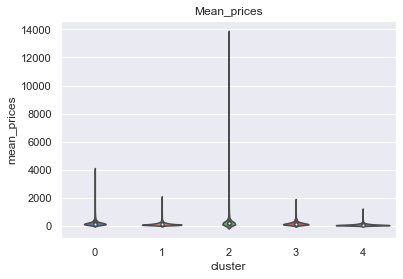

In [144]:
ax = sns.violinplot(x="cluster", y="mean_prices", data=X_sample)
ax.set_title('Mean_prices')

Text(0.5, 1.0, 'Mean_prices_log')

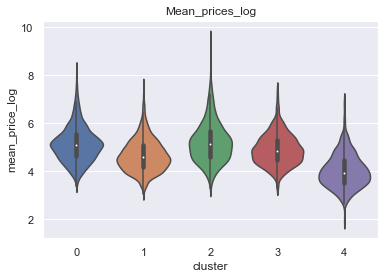

In [145]:
ax = sns.violinplot(x="cluster", y="mean_price_log", data=X_sample)
ax.set_title('Mean_prices_log')

Text(0.5, 1.0, 'Récence')

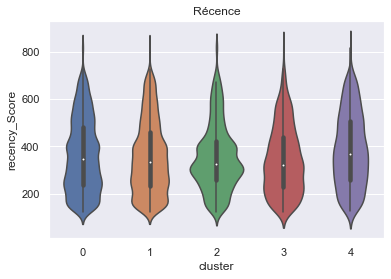

In [147]:
ax = sns.violinplot(x="cluster", y="recency_Score", data=X_sample)
ax.set_title('Récence')

Text(0.5, 1.0, 'Paiement en 1 fois')

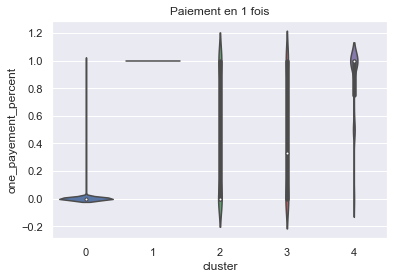

In [148]:
ax = sns.violinplot(x="cluster",
                    y="one_payement_percent",
                    data=X_sample)
ax.set_title('Paiement en 1 fois')

Text(0.5, 1.0, 'Review')

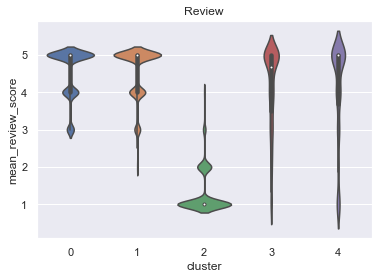

In [149]:
ax = sns.violinplot(x="cluster",
                    y="mean_review_score",
                    data=X_sample)
ax.set_title('Review')

Text(0.5, 1.0, '1 méthode de paiement')

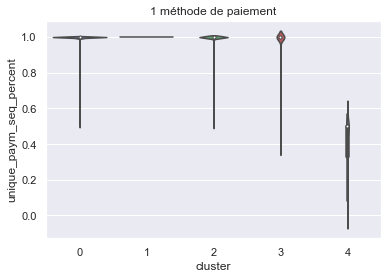

In [150]:
ax = sns.violinplot(x="cluster",
                    y="unique_paym_seq_percent",
                    data=X_sample)
ax.set_title('1 méthode de paiement')

Text(0.5, 1.0, 'Volume')

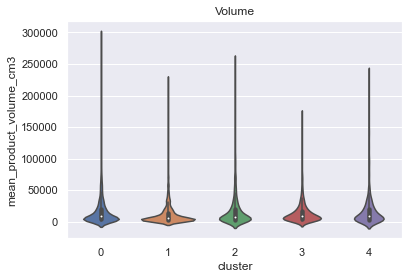

In [151]:
ax = sns.violinplot(x="cluster",
                    y="mean_product_volume_cm3",
                    data=X_sample)
ax.set_title('Volume')

Text(0.5, 1.0, 'Comment')

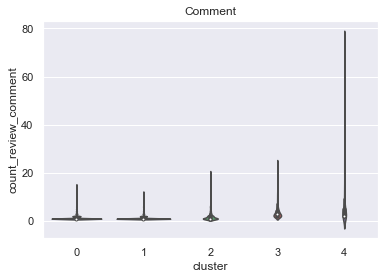

In [153]:
ax = sns.violinplot(x="cluster",
                    y="count_review_comment",
                    data=X_sample)
ax.set_title('Comment')

In [ ]:
ax = sns.violinplot(x="cluster",
                    y="mean_product_volume_log",
                    data=X_sample)

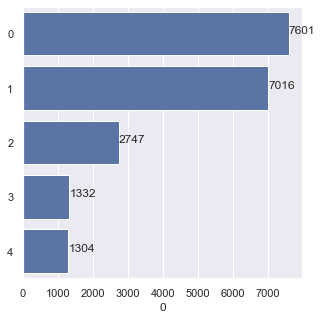

In [127]:
p5Lib.display_cate_bar(X_sample, 'cluster')

## 5. Performance et stabilité dans le temps

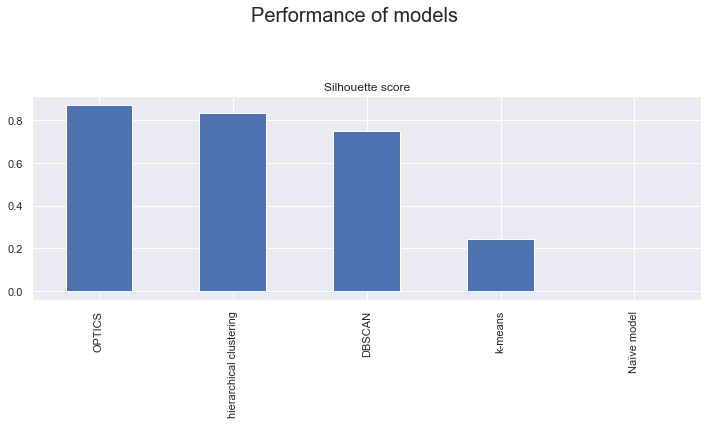

In [72]:
import matplotlib.gridspec as gridspec

fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Performance of models\n', fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
results_df['Silhouette'].sort_values(ascending=False).T.plot.bar(ax=ax1)

# Rotation of ticks labels
# plt.setp(ax1.get_xticklabels(), rotation='horizontal')
ax1.set_title("Silhouette score")

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.96])

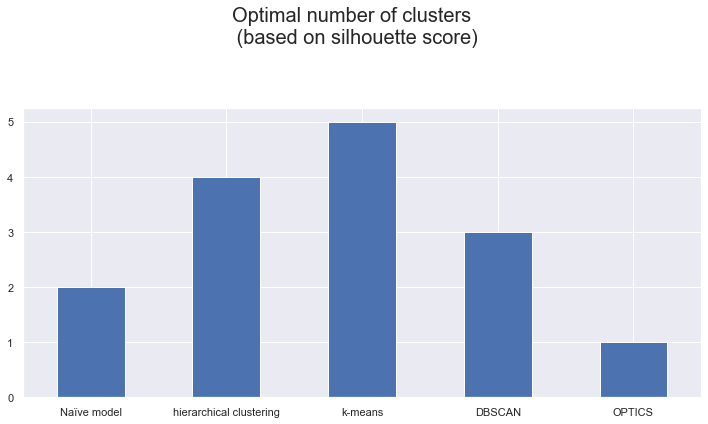

In [73]:
fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle(
    'Optimal number of clusters \n (based on silhouette score)',
    fontsize=20
)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
results_df['Nb of clusters'].T.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

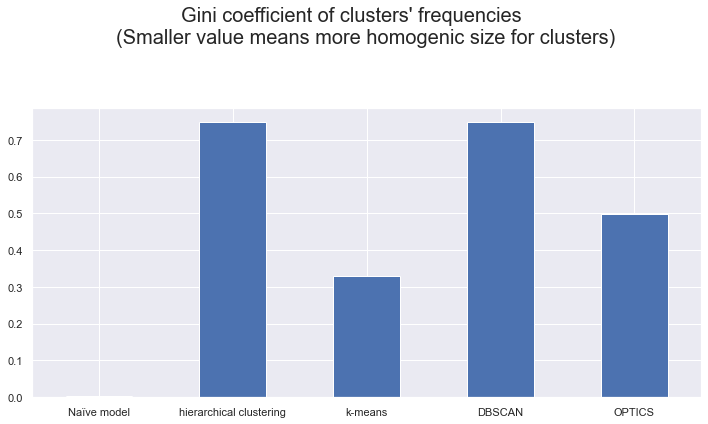

In [74]:
fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle(
    "Gini coefficient of clusters' frequencies \n\
    (Smaller value means more homogenic size for clusters)",
    fontsize=20
)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
results_df['Gini'].T.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

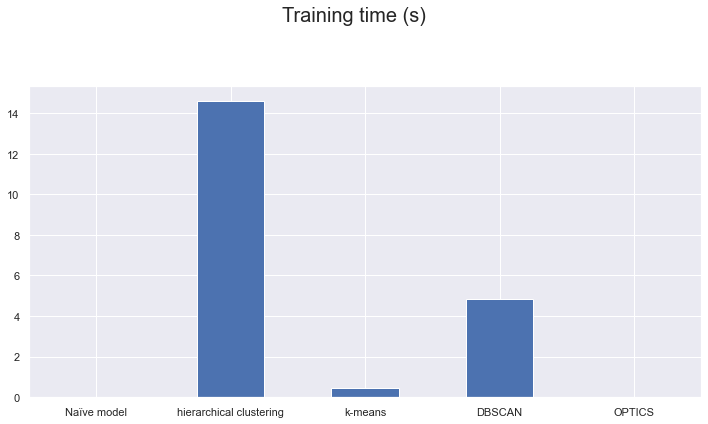

In [75]:
# Adding the training time to the results DataFrame
results_df.loc['hierarchical clustering', 'Training time (s)'] =\
    hierarchy_search.refit_time_
results_df.loc['k-means', 'Training time (s)'] = kmeans_search.refit_time_
results_df.loc['DBSCAN', 'Training time (s)'] = dbscan_search.refit_time_

# Set properties of the figure
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Training time (s)', fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
results_df['Training time (s)'].T.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

In [76]:
def initialisation_stability(model, nb_iter=5):

    from sklearn.metrics.cluster import adjusted_rand_score
    import statistics

    # Creating randomly initialized partitions for comparison
    # --------------------------------------------------------

    # Initializing the list of partitions
    partitions = []

    # Iterating
    for i in range(nb_iter):

        # Fitting the model
        model.fit(X_std)

        # Getting the results (labels of points)
        partitions.append(model.labels_)

    # Computing the ARI scores between partitions
    # --------------------------------------------------------

    # Initializing list of ARI scores
    ARI_scores = []

    # For each partition, except last one
    for i in range(nb_iter-1):
        # Compute the ARI score with other partitions
        for j in range(i+1, nb_iter):
            ARI_score = adjusted_rand_score(partitions[i], partitions[j])
            ARI_scores.append(ARI_score)

    # Compute the mean and standard deviation of ARI scores
    ARI_mean = statistics.mean(ARI_scores)
    ARI_std = statistics.stdev(ARI_scores)

    # Display results
    print(
        "Evaluation of stability upon random initialization:\
        {:.1f}%  ± {:.1f}% ".format(100*ARI_mean, 100*ARI_std))

    return ARI_scores


# Computing the metric of stability
stability_hierarchy = initialisation_stability(
    model=hierarchy_search.best_estimator_
)
stability_kmeans = initialisation_stability(
    model=kmeans_search.best_estimator_
)
stability_dbscan = initialisation_stability(
    model=dbscan_search.best_estimator_
)
stability_optics = initialisation_stability(
    model=optics_search.best_estimator_
)

Evaluation of stability upon random initialization:        100.0%  ± 0.0% 
Evaluation of stability upon random initialization:        75.5%  ± 31.6% 
Evaluation of stability upon random initialization:        100.0%  ± 0.0% 


C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning:

divide by zero encountered in true_divide



Evaluation of stability upon random initialization:        100.0%  ± 0.0% 


C:\Users\tfavr\anaconda3\envs\Work\lib\site-packages\sklearn\cluster\_optics.py:804: RuntimeWarning:

divide by zero encountered in true_divide



In [77]:
stability_kmeans = initialisation_stability(
    model=kmeans_search.best_estimator_
)

Evaluation of stability upon random initialization:        99.9%  ± 0.1% 


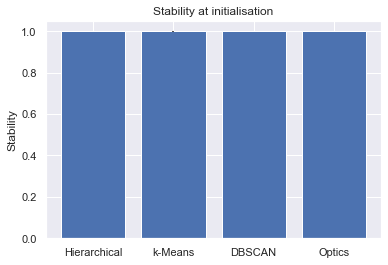

In [78]:
import statistics

means = [
    statistics.mean(stability_hierarchy),
    statistics.mean(stability_kmeans),
    statistics.mean(stability_dbscan),
    statistics.mean(stability_optics),
        ]

std_errors = [
    statistics.stdev(stability_hierarchy),
    statistics.stdev(stability_kmeans),
    statistics.stdev(stability_dbscan),
    statistics.stdev(stability_optics),
]

ind = np.arange(4)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

plt.bar(ind, means, yerr=std_errors)

plt.ylabel('Stability')
plt.title('Stability at initialisation')
plt.xticks(ind, ('Hierarchical', 'k-Means', 'DBSCAN', 'Optics'))

plt.show()

In [79]:
# Sampling
data_customers_ = data_PCA.sample(n=20000, random_state=5)
data_customers_ = data_customers_.reset_index()

# Get the data about customers, before PCA
data_encoded = pd.read_csv(r"data\cleaned\p5_data_encoded.csv")

# Get the 'timestamps' of orders
data_timestamps = pd.to_datetime(data_encoded['last_order_purchase_timestamp'])

# Apply the same sampling as data_customers

mask = data_timestamps.index.isin(data_customers_.index)
data_timestamps = data_timestamps[mask]

In [80]:
# Get main temporal informations from data set
date_min = data_timestamps.min()
date_max = data_timestamps.max()
duration = date_max - date_min

print('The data set covers a period of {} days, from {} to {}.'
      .format(duration.days, date_min.date(), date_max.date()))

The data set covers a period of 694 days, from 2016-10-03 to 2018-08-29.


In [81]:
%pycodestyle_off
def time_stability(model, nb_iter=5, init_centroid=False):

    from datetime import datetime, timedelta
    from sklearn.metrics.cluster import adjusted_rand_score
    from sklearn import cluster

    # Setting the initial data set to one year of data
    date_init = date_min + timedelta(days=365)

    # Getting the initial data set
    timemask = (data_timestamps < date_init)
    X_init_std = data_customers_[timemask] #premiere année

    # Fitting the model on intial data
    model.fit(X_init_std)

    # Predicting the initial clusters labels for initial customers
    clusters_init = model.labels_

    # Initializations
    ARI_results = pd.DataFrame()
    index = -1
    date_lim = date_init

    # Iterating until we reach the maximum date in data set
    while date_lim < date_max:
        index +=1
        # getting the new data truncated
        timemask = (data_timestamps < date_lim)
        X_trunc = data_customers_[timemask]

        # standardisation and PCA
        X_trunc_std = X_trunc

        # iterating for stability and standard deviation of scores
        # --------------------------------------------------------
        ARI_scores = []

        # fitting a new model on the truncated data
        model.fit(X_trunc_std)

        # Creating a mask for customers in initial partition
        list_init = X_init_std.index
        mask = X_trunc_std.index.isin(list_init)

        # Getting the labels for the initial customers
        clusters_new = model.labels_[mask]

        # Computing and saving ARI score between initial clustering and new ones
        ARI_score = adjusted_rand_score(clusters_init, clusters_new)
        ARI_scores.append(ARI_score)

        # Add timestamp and ARI scores to the results pd.DataFrame
        ARI_results.loc[index, 'period'] = date_lim # - date_init
        ARI_results.loc[index, 'ARI_score_mean'] =  np.mean(ARI_scores)
        ARI_results.loc[index, 'ARI_score_std'] =  np.std(ARI_scores)

        # increase timelimit by 30 days for next iteration
        date_lim += timedelta(days=30)

    return ARI_results

%pycodestyle_on

In [82]:
# Getting results of time stability for each model
hierarchy_stability = time_stability(model=hierarchy_search.best_estimator_)
kmeans_stability = time_stability(
    model=kmeans_search.best_estimator_,
    init_centroid=True
)
dbscan_stability = time_stability(model=dbscan_search.best_estimator_)

optics_stability = time_stability(model=optics_search.best_estimator_)

KMeans(n_clusters=5, random_state=5)

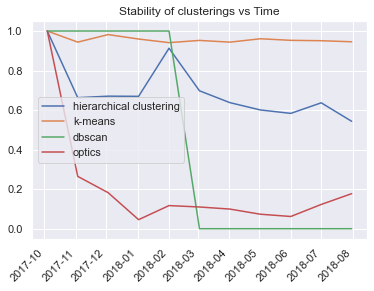

In [83]:
x = hierarchy_stability['period']
plt.plot(
    x,
    hierarchy_stability['ARI_score_mean'],
    label='hierarchical clustering'
)
plt.plot(x, kmeans_stability['ARI_score_mean'], label='k-means')
plt.plot(x, dbscan_stability['ARI_score_mean'], label='dbscan')
plt.plot(x, optics_stability['ARI_score_mean'], label='optics')
plt.legend()
plt.title("Stability of clusterings vs Time")
plt.xticks(rotation='45', horizontalalignment="right")
plt.show()